# Tensorflow VGG16 implementation
本習題將使用tensorflow實作VGG16模型，用於Where am i的競賽當中，將不會使用遷移學習而是以重新訓練網絡的方式進行。

In [1]:
import os

import cv2
import numpy as np
import imutils
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from keras.utils import to_categorical
import progressbar

import progressbar

import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

Using TensorFlow backend.


In [2]:
TRAIN_ROOT = 'train'
TEST_ROOT = 'testset'

In [3]:
def get_images_and_labels(root):
    images, labels = [], []
    df = []
    for path, dic, files in os.walk(root):
        for file in files:
            if file.endswith('.jpg'):
                df.append([os.path.join(path, file), path.split('\\')[1]])
                
    return pd.DataFrame(df, columns=['img_path', 'label'])

In [4]:
def get_test_set(root):
    paths = []
    for path, dic, files in os.walk(root):
        for file in files:
            if file.endswith('.jpg'):
                paths.append([os.path.join(path, file)])                
    return pd.DataFrame(paths, columns=['img_path'])

In [5]:
img_df = get_images_and_labels(TRAIN_ROOT)
NUM_CLASSES = len(list(set(img_df.label.values)))
test_df = get_test_set(TEST_ROOT)

** 圖片寬高與比例 **
<br>觀察圖片寬高以及比例的分布，作為前處理的依據

In [6]:
width, height, ratio = [], [], []
pbar = progressbar.ProgressBar(max_value=len(img_df))
pbar.start()

for i, row in img_df.iterrows():
    image = cv2.imread(row.img_path)
    width.append(image.shape[1])
    height.append(image.shape[0])
    ratio.append(image.shape[0] / image.shape[1])
    pbar.update(i)
    
img_df['width'] = width
img_df['height'] = height
img_df['ratio'] = ratio

 97% (2910 of 2985) |################### | Elapsed Time: 0:00:02 ETA:   0:00:00

In [7]:
width, height, ratio = [], [], []
pbar = progressbar.ProgressBar(max_value=len(img_df))
pbar.start()

for i, row in test_df.iterrows():
    image = cv2.imread(row.img_path)
    width.append(image.shape[1])
    height.append(image.shape[0])
    ratio.append(image.shape[0] / image.shape[1])
    pbar.update(i)
    
test_df['width'] = width
test_df['height'] = height
test_df['ratio'] = ratio

 48% (1436 of 2985) |#########           | Elapsed Time: 0:00:01 ETA:   0:00:01

** 寬度 **
<br>寬度的分布大部分落在256pixels

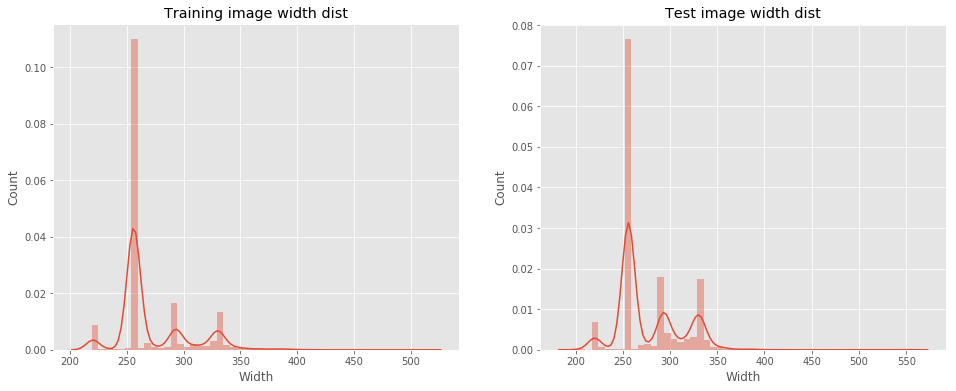

In [8]:
fig=plt.gcf()
fig.set_size_inches(16, 6)
plt.subplot(121)
sns.distplot(img_df.width);
plt.title("Training image width dist")
plt.xlabel("Width")
plt.ylabel("Count")

plt.subplot(122)
sns.distplot(test_df.width);
plt.title("Test image width dist")
plt.xlabel("Width")
plt.ylabel("Count")
plt.show()

** 高度 **
<br>寬度的分布大部分落在256pixels

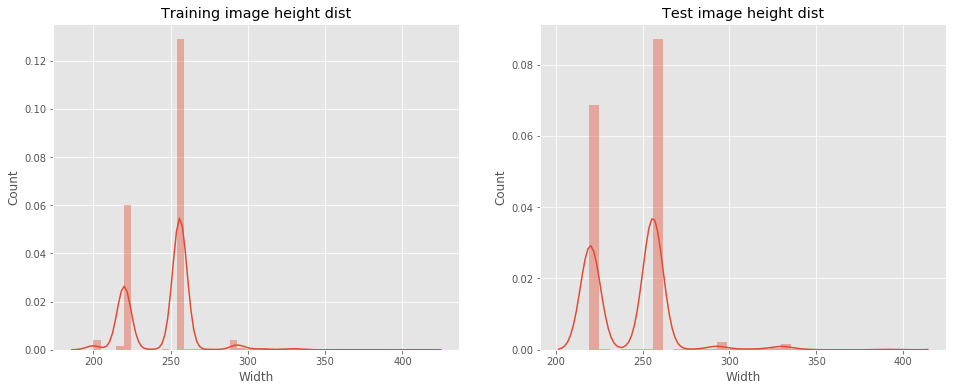

In [9]:
fig=plt.gcf()
fig.set_size_inches(16, 6)
plt.subplot(121)
sns.distplot(img_df.height);
plt.title("Training image height dist")
plt.xlabel("Width")
plt.ylabel("Count")

plt.subplot(122)
sns.distplot(test_df.height);
plt.title("Test image height dist")
plt.xlabel("Width")
plt.ylabel("Count")
plt.show()

** 高寬比例 **
<br>大部分的圖片高寬比例為1:1

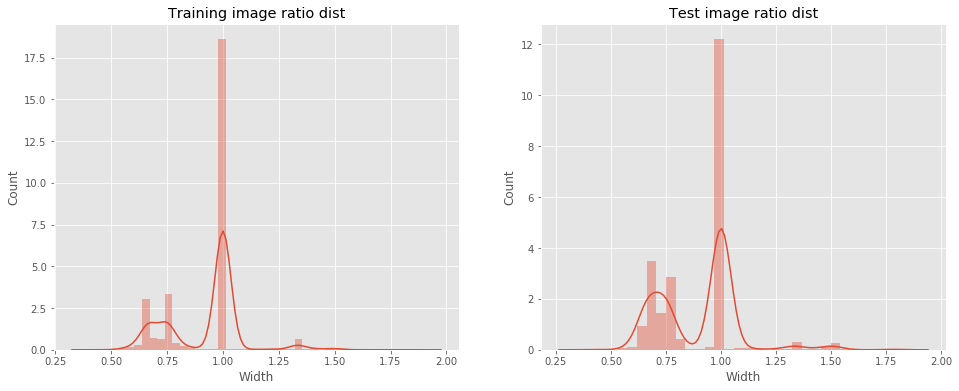

In [10]:
fig=plt.gcf()
fig.set_size_inches(16, 6)
plt.subplot(121)
sns.distplot(img_df.ratio);
plt.title("Training image ratio dist")
plt.xlabel("Width")
plt.ylabel("Count")

plt.subplot(122)
sns.distplot(test_df.ratio);
plt.title("Test image ratio dist")
plt.xlabel("Width")
plt.ylabel("Count")
plt.show()

## 2.Feature engineering
<li>透過預處理將比例非對等的圖片處理成1:1的尺寸</li>
<li>label one hot encoding</li>

### 2.1
** 圖片處理策略 **
>所有的圖片在寬、高、比例上均有集中的趨勢，因此將採用1:1圖片的比例以及配合VGG16而將圖像解析度定為224*224，若比例原本是1:1的圖片可以直接resize，而寬高比例非1:1的圖片將加速像素填補短邊的部分

In [11]:
def make_square_by_padding(im, desired_size=224):
    old_size = im.shape[:2] # old_size is in (height, width) format

    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])

    # new_size should be in (width, height) format

    im = cv2.resize(im, (new_size[1], new_size[0]))

    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,
        value=color)

    return new_im

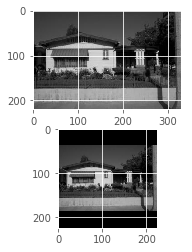

In [12]:
demo_img = cv2.imread('train\CALsuburb\image_0001.jpg')
filled_with_zero = make_square_by_padding(demo_img)

plt.figure(1)
plt.subplot(211)
plt.imshow(demo_img)

plt.subplot(212)
plt.imshow(filled_with_zero)
plt.show()

### Preprocessing

In [13]:
ft_set = np.array([make_square_by_padding(cv2.imread(row.img_path)) for _, row in img_df.iterrows()])
ft_set = ft_set.reshape((len(ft_set), 224, 224, 3))
ft_set.shape

(2985, 224, 224, 3)

### Image augmentation
透過圖像處理產生更多樣性的訓練資料

In [15]:
import imgaug as ia
from imgaug import augmenters as iaa

sometimes = lambda aug: iaa.Sometimes(0.5, aug)

seq = iaa.Sequential(
    [
        # apply the following augmenters to most images
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
#         iaa.Flipud(0.2), # vertically flip 20% of all images
        # crop images by -5% to 10% of their height/width
        sometimes(iaa.CropAndPad(
            percent=(-0.05, 0.1),
            pad_mode=ia.ALL,
            pad_cval=(0, 255)
        )),
        sometimes(iaa.Affine(
            scale={"x": (0.95, 1.02), "y": (0.95, 1.02)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            rotate=(-10, 10), # rotate by -45 to +45 degrees
            shear=(-16, 16), # shear by -16 to +16 degrees
            order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
            cval=(0, 255), # if mode is constant, use a cval between 0 and 255
            mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        )),
        # execute 0 to 5 of the following (less important) augmenters per image
        # don't execute all of them, as that would often be way too strong
        iaa.SomeOf((0, 5),
            [
                sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                iaa.OneOf([
                    iaa.GaussianBlur((0, 3.0)), # blur images with a sigma between 0 and 3.0
                    iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
                    iaa.MedianBlur(k=(3, 11)), # blur image using local medians with kernel sizes between 2 and 7
                ]),
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
                iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                # search either for all edges or for directed edges,
                # blend the result with the original image using a blobby mask
                iaa.SimplexNoiseAlpha(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0.5, 1.0)),
                    iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                ])),
                iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise to images
                iaa.OneOf([
                    iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
                    iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                ]),
                iaa.Invert(0.05, per_channel=True), # invert color channels
                iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                iaa.AddToHueAndSaturation((-20, 20)), # change hue and saturation
                # either change the brightness of the whole image (sometimes
                # per channel) or change the brightness of subareas
                iaa.OneOf([
                    iaa.Multiply((0.5, 1.5), per_channel=0.5),
                    iaa.FrequencyNoiseAlpha(
                        exponent=(-4, 0),
                        first=iaa.Multiply((0.5, 1.5), per_channel=True),
                        second=iaa.ContrastNormalization((0.5, 2.0))
                    )
                ]),
                iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5), # improve or worsen the contrast
                iaa.Grayscale(alpha=(0.0, 1.0)),
                sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
                sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
            ],
            random_order=True
        )
    ],
    random_order=True
)

### augmentation example
經過圖像處理，一張圖片有數種不同的樣貌

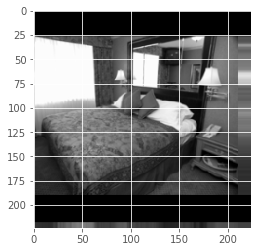

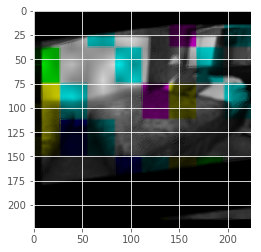

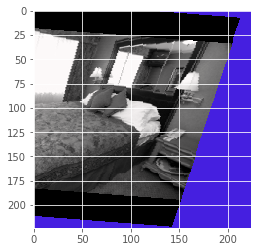

C:\Users\User\AppData\Local\conda\conda\envs\ds\lib\site-packages\skimage\segmentation\slic_superpixels.py:156: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  segments_z = grid_z[slices]
C:\Users\User\AppData\Local\conda\conda\envs\ds\lib\site-packages\skimage\segmentation\slic_superpixels.py:157: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  segments_y = grid_y[slices]
C:\Users\User\AppData\Local\conda\conda\envs\ds\lib\site-packages\skimage\segmentation\slic_superpixels.py:158: FutureWarning: Using a non-tuple sequence for multidimension

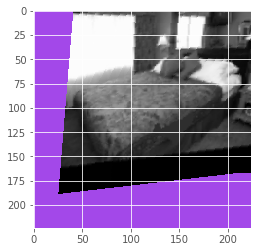

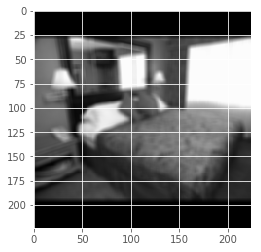

In [16]:
for i in range(5):
    temp_img = ft_set[0].copy().reshape((1, 224, 224, 3))
    plt.imshow(seq.augment_images(temp_img)[0])
    plt.show()

### 2.2 One hot label

In [17]:
class_mapping = {
'CALsuburb': 9,
'PARoffice': 7,
'bedroom': 12,
'coast': 10,
'forest': 4,
'highway': 14,
'industrial': 2,
'insidecity': 3,
'kitchen': 0,
'livingroom': 5,
'mountain': 8,
'opencountry': 6,
'store': 11,
'street': 1,
'tallbuilding': 13}

In [18]:
img_df['int_label'] = img_df['label'].map(class_mapping)
labels_one_hot = to_categorical(img_df['int_label'])

** 分層採樣 **
<br>分層採樣train/test set，因為類別的數量並不一致，因此分層採樣有助於避免抽樣的偏誤

In [19]:
from sklearn.model_selection import StratifiedShuffleSplit

In [20]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(ft_set, img_df.int_label):
    
    ft_set_strat_train_x = np.array([ft_set[i] for i in train_index])
    ft_set_strat_train_y = np.uint8([labels_one_hot[i] for i in train_index])
    ft_set_strat_test_x = np.array([ft_set[i] for i in test_index])
    ft_set_strat_test_y = np.uint8([labels_one_hot[i] for i in test_index])

In [21]:
ft_set_strat_train_x.shape

(2388, 224, 224, 3)

## 3.Training

** Vgg16 **
<br>以Vgg16作為採用的分類模型

In [22]:
import tensorflow as tf
import time
from sklearn.model_selection import train_test_split

In [23]:
class Vgg16:
    vgg_mean = [103.939, 116.779, 123.68]

    def __init__(self, vgg16_npy_path='./vgg16.npy', restore_from=None):
        # pre-trained parameters
        try:
            self.data_dict = np.load(vgg16_npy_path, encoding='latin1').item()
        except FileNotFoundError:
            print('Please download VGG16 parameters from here https://mega.nz/#!YU1FWJrA!O1ywiCS2IiOlUCtCpI6HTJOMrneN-Qdv3ywQP5poecM\nOr from my Baidu Cloud: https://pan.baidu.com/s/1Spps1Wy0bvrQHH2IMkRfpg')

        self.tfx = tf.placeholder(tf.float32, [None, 224, 224, 3])
        self.tfy = tf.placeholder(tf.float32, [None, 15])

        # Convert RGB to BGR
        red, green, blue = tf.split(axis=3, num_or_size_splits=3, value=self.tfx * 255.0)
        bgr = tf.concat(axis=3, values=[
            blue - self.vgg_mean[0],
            green - self.vgg_mean[1],
            red - self.vgg_mean[2],
        ])

        # pre-trained VGG layers are fixed in fine-tune
        conv1_1 = self.conv_layer(bgr, "conv1_1")
        conv1_2 = self.conv_layer(conv1_1, "conv1_2")
        pool1 = self.max_pool(conv1_2, 'pool1')

        conv2_1 = self.conv_layer(pool1, "conv2_1")
        conv2_2 = self.conv_layer(conv2_1, "conv2_2")
        pool2 = self.max_pool(conv2_2, 'pool2')

        conv3_1 = self.conv_layer(pool2, "conv3_1")
        conv3_2 = self.conv_layer(conv3_1, "conv3_2")
        conv3_3 = self.conv_layer(conv3_2, "conv3_3")
        pool3 = self.max_pool(conv3_3, 'pool3')

        conv4_1 = self.conv_layer(pool3, "conv4_1")
        conv4_2 = self.conv_layer(conv4_1, "conv4_2")
        conv4_3 = self.conv_layer(conv4_2, "conv4_3")
        pool4 = self.max_pool(conv4_3, 'pool4')

        conv5_1 = self.conv_layer(pool4, "conv5_1")
        conv5_2 = self.conv_layer(conv5_1, "conv5_2")
        conv5_3 = self.conv_layer(conv5_2, "conv5_3")
        pool5 = self.max_pool(conv5_3, 'pool5')

        # detach original VGG fc layers and
        # reconstruct your own fc layers serve for your own purpose
        self.flatten = tf.reshape(pool5, [-1, 7*7*512])
        self.fc6 = tf.layers.dense(self.flatten, 256, tf.nn.relu, name='fc6')
        self.out = tf.layers.dense(self.fc6, 15, name='out')

        self.sess = tf.Session()
        if restore_from:
            saver = tf.train.Saver()
            saver.restore(self.sess, restore_from)
        else:   # training graph
            self.pred = tf.argmax(self.out,1)
            self.truth = tf.argmax(self.tfy,1)
            self.correct_pred = tf.equal(self.pred, self.truth)
            self.accuracy = tf.reduce_mean(tf.cast(self.correct_pred, tf.float32))
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = self.out, labels = self.tfy))

            self.train_op = tf.train.RMSPropOptimizer(0.001).minimize(self.loss)
            self.sess.run(tf.global_variables_initializer())

    def max_pool(self, bottom, name):
        return tf.nn.max_pool(bottom, ksize=[1, 2, 2, 1], 
                              strides=[1, 2, 2, 1], 
                              padding='SAME', 
                              name=name)

    def conv_layer(self, bottom, name):
        with tf.variable_scope(name):   # CNN's filter is constant, NOT Variable that can be trained
            conv = tf.nn.conv2d(bottom, self.data_dict[name][0], [1, 1, 1, 1], padding='SAME')
            lout = tf.nn.relu(tf.nn.bias_add(conv, self.data_dict[name][1]))
            return lout

    def fit(self, x, y, batch_size=48, epochs=70):
        batch_steps = len(x) // batch_size
        
        for epoch in range(epochs):
            train_accuracies, train_losses = [], []
            test_accuracies, test_losses = [], []
            for step in range(batch_steps):
                batch_x = x[step:step+batch_size].copy()
                batch_x = seq.augment_images(batch_x)
                batch_y = y[step:step+batch_size]
                
                train_x, valid_x, train_y, valid_y = train_test_split(batch_x, batch_y, test_size=0.2)
                
                train_feed = {self.tfx:train_x, self.tfy:train_y}
                valid_feed = {self.tfx:valid_x, self.tfy:valid_y}
                
                train_loss, train_accuracy, _ = self.sess.run([self.loss, self.accuracy, self.train_op], train_feed)
                test_loss, test_accuracy, _ = self.sess.run([self.loss, self.accuracy, self.train_op], valid_feed)
                
                train_accuracies.append(train_accuracy)
                train_losses.append(train_loss)
                test_accuracies.append(test_accuracy)
                test_losses.append(test_loss)
                
            print('epoch:', epoch)
            print('training_ccuracy', np.mean(train_accuracies), 'training_loss:', np.mean(train_losses))
            print('valid_accuracy', np.mean(test_accuracies), 'valid_loss:', np.mean(test_losses))
            print('----------------------------------------------------')

    def predict(self, xs):
        preds = []
        for row in xs:
            pred = self.sess.run(self.pred, {self.tfx: row.reshape((1, 224, 224, 3))})
            preds.append(pred[0])
        return np.array(preds, np.uint8)

    def save(self, path=r'./'):
        saver = tf.train.Saver()
        saver.save(self.sess, path, write_meta_graph=False)

In [24]:
net = Vgg16()
net.fit(ft_set_strat_train_x, ft_set_strat_train_y)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



C:\Users\User\AppData\Local\conda\conda\envs\ds\lib\site-packages\skimage\segmentation\slic_superpixels.py:156: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  segments_z = grid_z[slices]
C:\Users\User\AppData\Local\conda\conda\envs\ds\lib\site-packages\skimage\segmentation\slic_superpixels.py:157: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  segments_y = grid_y[slices]
C:\Users\User\AppData\Local\conda\conda\envs\ds\lib\site-packages\skimage\segmentation\slic_superpixels.py:158: FutureWarning: Using a non-tuple sequence for multidimension

epoch: 0
training_ccuracy 0.6788399 training_loss: 1546.836
valid_accuracy 0.7 valid_loss: 1435.0415
----------------------------------------------------
epoch: 1
training_ccuracy 0.7798066 training_loss: 418.81702
valid_accuracy 0.79183674 valid_loss: 325.351
----------------------------------------------------
epoch: 2
training_ccuracy 0.7502685 training_loss: 127.888535
valid_accuracy 0.72244895 valid_loss: 112.37689
----------------------------------------------------
epoch: 3
training_ccuracy 0.58968854 training_loss: 22.407099
valid_accuracy 0.55714285 valid_loss: 22.594606
----------------------------------------------------
epoch: 4
training_ccuracy 0.52900106 training_loss: 7.5888834
valid_accuracy 0.51428574 valid_loss: 5.364463
----------------------------------------------------
epoch: 5
training_ccuracy 0.55907625 training_loss: 7.4255195
valid_accuracy 0.53061223 valid_loss: 6.216028
----------------------------------------------------
epoch: 6
training_ccuracy 0.5907627 

epoch: 51
training_ccuracy 0.7572502 training_loss: 1.487921
valid_accuracy 0.78571427 valid_loss: 1.0220811
----------------------------------------------------
epoch: 52
training_ccuracy 0.77873254 training_loss: 3.515076
valid_accuracy 0.7877551 valid_loss: 3.1384277
----------------------------------------------------
epoch: 53
training_ccuracy 0.75939846 training_loss: 3.1732328
valid_accuracy 0.7632653 valid_loss: 2.8329923
----------------------------------------------------
epoch: 54
training_ccuracy 0.7819549 training_loss: 3.5523567
valid_accuracy 0.7653061 valid_loss: 9.174466
----------------------------------------------------
epoch: 55
training_ccuracy 0.7755102 training_loss: 1.5090685
valid_accuracy 0.78571427 valid_loss: 3.6968691
----------------------------------------------------
epoch: 56
training_ccuracy 0.7604726 training_loss: 2.0309103
valid_accuracy 0.7918368 valid_loss: 0.7883578
----------------------------------------------------
epoch: 57
training_ccuracy 

### Evaluation

In [33]:
from sklearn.metrics import confusion_matrix, accuracy_score

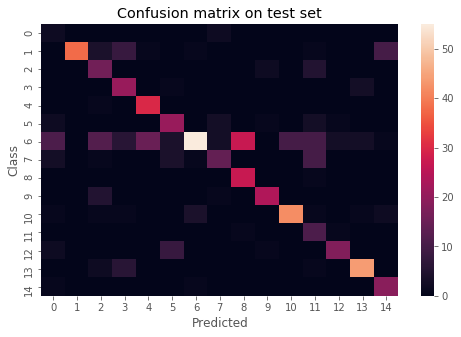

In [36]:
y_pred = predict(ft_set_strat_test_x)
truth = [np.argmax(row) for row in ft_set_strat_test_y]
plt.figure(figsize=(8, 5))
sns.heatmap(confusion_matrix(y_pred, truth))
plt.title("Confusion matrix on test set")
plt.xlabel("Predicted")
plt.ylabel("Class")
plt.show()

In [32]:
test_set = np.array([make_square_by_padding(cv2.imread(row.img_path)) for _, row in test_df.iterrows()])

submission = pd.DataFrame()
submission['id'] = test_df.img_path.apply(lambda _path:_path.split('\\')[1].split('.')[0])
y_pred = net.predict(test_set)
submission['class'] = y_pred
submission.to_csv('submissions/ensorflow_submission_v1.csv', index=False)

<img src='images/tensorflow_v1.jpg'>